In [1]:
import warnings
import os 
from pathlib import Path
import pandas as pd 
from logbook import Logger, StderrHandler, INFO, WARNING
import numpy as np 

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission, set_max_leverage,
                         order_target, order_target_percent,
                         get_open_orders, cancel_order, set_benchmark, symbol,
                         set_long_only
                        )
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import KR_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.factors import AverageDollarVolume, Returns
from zipline.pipeline.loaders import KREquityPricingLoader
from zipline.pipeline.loaders.frame import DataFrameLoader
from trading_calendars import get_calendar

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

In [2]:
warnings.filterwarnings('ignore')

## Load Zipline Extension

In [3]:
os.environ['ZIPLINE_ROOT'] = 'C:/Users/PC/.zipline/'

In [4]:
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

In [5]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=WARNING)
log_handler.push_application()
log = Logger('Algorithm')

## Algo Params

In [59]:
N_LONGS = 20
VOL_SCREEN = 650

## Load DataReader Bundles

In [7]:
bundle_data = bundles.load('fnguide')

In [8]:
idx = pd.IndexSlice

In [11]:
def load_factor(bundle):
    with pd.HDFStore('../factor.h5') as store: 
        pbr = (store['value/pbr']
                   .loc[idx['2000':'2020', :], :]
                  )
        pbr = pbr[pbr['PBR'] > 0]
    tickers = pbr.index.get_level_values('ticker').unique().tolist()
    
    assets = []
    for ticker in tickers:
        try:
            asset = bundle.asset_finder.lookup_symbol(ticker, as_of_date=None)
            assets.append(asset)
        except Exception as e:
            print(e)
    factor_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, factor_sids))
    return (pbr
            .unstack('ticker')
            .rename(columns=ticker_map)
            .PBR
            .tz_localize('UTC')
            .fillna(method='ffill')
           ), assets

In [12]:
pbr, assets = load_factor(bundle_data)

In [13]:
pbr 

ticker,1,4,5,9,11,14,20,21,23,27,30,31,32,36,37,38,39,41,42,46,47,48,49,50,52,55,56,63,65,69,74,75,78,79,83,84,87,88,89,91,92,94,95,96,99,102,103,106,107,108,109,111,113,116,118,121,123,124,127,129,...,933,724,1100,1060,1087,1099,1063,1098,954,1105,1106,1110,1112,1107,1108,1109,864,1113,1114,1116,986,1118,1119,1120,1121,746,903,922,1117,1122,1123,1126,1127,1128,1129,1130,981,1124,1132,547,1134,1025,1077,1081,1111,1125,1131,1135,1137,242,1115,1138,865,1136,1141,1142,1139,1146,1148,1140
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00+00:00,0.554117,0.659127,0.477730,0.698383,0.508972,0.783295,0.490559,0.486961,1.844471,0.272190,0.423812,0.831179,0.412508,1.442068,0.325846,0.276105,0.186168,0.691578,0.914669,0.614683,1.052570,1.265264,3.541974,0.308802,0.686526,0.334788,27.921789,0.358359,0.376729,0.197723,0.069292,0.488676,0.897356,0.624034,0.775164,0.973996,0.602788,0.365466,0.894237,0.649738,0.373015,0.172922,2.060051,0.055066,0.286388,0.634594,0.285739,9.952294,0.099456,0.189971,0.801296,1.894824,23.093811,0.456336,0.567871,0.398116,0.647194,0.229019,1.008938,2.783302,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04 00:00:00+00:00,0.637137,0.619589,0.501616,0.758746,0.558738,0.712571,0.517046,0.533657,1.909417,0.269421,0.471964,0.843584,0.443767,1.507605,0.293900,0.262607,0.188979,0.743824,1.008333,0.662748,1.208950,1.240592,3.784475,0.311487,0.736878,0.347502,31.238459,0.344443,0.369995,0.200586,0.069292,0.505555,0.887379,0.649583,0.766528,1.082218,0.627903,0.410091,0.964496,0.657640,0.397162,0.167715,2.354346,0.063259,0.285031,0.701005,0.284948,10.820221,0.103642,0.174568,0.863781,1.868505,23.695936,0.468695,0.577203,0.411735,0.730704,0.225104,1.054146,3.198123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05 00:00:00+00:00,0.675750,0.603763,0.576860,0.744654,0.570048,0.720577,0.511152,0.553676,1.805503,0.260284,0.447552,0.831179,0.465637,1.468270,0.297095,0.262607,0.187730,0.685078,0.955082,0.656192,1.389349,1.173533,3.395004,0.272821,0.778636,0.339026,29.695819,0.323228,0.349588,0.198038,0.066627,0.523269,0.897356,0.746819,0.780469,1.053358,0.637332,0.403842,0.913398,0.623397,0.391477,0.192837,2.243990,0.065075,0.263315,0.678868,0.286923,10.338039,0.168241,0.169434,0.791952,1.883690,26.993729,0.456977,0.541784,0.410686,0.699385,0.230977,1.084095,3.462403,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06 00:00:00+00:00,0.586942,0.630122,0.558347,0.695878,0.538379,0.677878,0.497647,0.513660,1.727568,0.245067,0.440762,0.833660,0.440637,1.376530,0.281122,0.245424,0.181170,0.621145,0.942208,0.644547,1.238566,1.190297,3.218640,0.278192,0.716000,0.334788,27.304723,0.323575,0.352139,0.184667,0.065960,0.502179,0.897356,0.800675,0.747018,0.988423,0.612217,0.369486,0.859745,0.583886,0.378247,0.221700,2.111548,0.061438,0.266301,0.619836,0.282183,9.720846,0.159785,0.167894,0.744085,1.891700,30.893646,0.426512,0.512267,0.389733,0.657634,0.234891,1.045162,3.178052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07 00:00:00+00:00,0.676459,0.601117,0.561333,0.728395,0.551952,0.692556,0.528163,0.533657,1.688600,0.244306,0.427202,0.865915,

## Define Custom Dataset

In [16]:
class PBRData(DataSet):
    pbr = Column(dtype=float)
    domain = KR_EQUITIES

## Define Pipeline Loaders

In [17]:
pbr_loader = {PBRData.pbr: DataFrameLoader(PBRData.pbr, pbr)}

## Pipeline & Setup

In [20]:
class PBR(CustomFactor):
    inputs = [PBRData.pbr]
    window_length = 1
    
    def compute(self, today, assets, out, pbr):
        out[:] = pbr

## Create Pipeline

In [105]:
def compute_factors():
    pbr = PBR()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={
        'longs': pbr.bottom(N_LONGS),
        'ranking': pbr.rank(ascending=False),
        },
        screen=dollar_volume.top(600)
    )

## Initialize Algorithm

In [106]:
def exec_trades(data, assets, target_percent):
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

In [107]:
def rebalance(context, data):
    print(context.datetime)
    factor_data = pipeline_output('factor_pipeline')
    record(factor_data=factor_data.ranking)

    assets = factor_data.index
    record(prices=data.current(assets, 'price'))

    longs = assets[factor_data.longs]
    divest = set(context.portfolio.positions.keys()) - set(longs)

    # 보유 주식 처분
    exec_trades(data, assets=divest, target_percent=0)
    # 새롭게 리밸런싱
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS)

In [108]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.universe = assets
    context.longs = 0
    set_long_only()
    set_benchmark(symbol('kospi'))
    set_slippage(slippage.FixedSlippage(spread=0.01))
    set_commission(commission.PerShare(cost=0.002, min_trade_cost=0))

    attach_pipeline(pipeline=compute_factors(), name='factor_pipeline')
    schedule_function(rebalance,
                      date_rules.month_end(),
                      time_rules.market_close())       

In [109]:
start = pd.Timestamp('2000-01-01', tz='utc')
end = pd.Timestamp('2021-07-01', tz='utc')

## Start BackTest

In [110]:
results = run_algorithm(start=start,
                        end=end,
                        initialize=initialize,
                        capital_base=1e6,
                        data_frequency='daily',
                        bundle='fnguide',
                        trading_calendar=get_calendar('XKRX'),
                        custom_loader=pbr_loader
                       )

2000-01-31 06:30:00+00:00
2000-02-29 06:30:00+00:00
2000-03-31 06:30:00+00:00
2000-04-28 06:30:00+00:00
2000-05-31 06:30:00+00:00
2000-06-30 06:30:00+00:00
2000-07-31 06:30:00+00:00
2000-08-31 06:30:00+00:00
2000-09-29 06:30:00+00:00
2000-10-31 06:30:00+00:00
2000-11-30 06:30:00+00:00
2000-12-26 06:30:00+00:00
2001-01-31 06:30:00+00:00
2001-02-28 06:30:00+00:00
2001-03-30 06:30:00+00:00
2001-04-30 06:30:00+00:00
2001-05-31 06:30:00+00:00
2001-06-29 06:30:00+00:00
2001-07-31 06:30:00+00:00
2001-08-31 06:30:00+00:00
2001-09-28 06:30:00+00:00
2001-10-31 06:30:00+00:00
2001-11-30 06:30:00+00:00
2001-12-28 06:30:00+00:00
2002-01-31 06:30:00+00:00
2002-02-28 06:30:00+00:00
2002-03-29 06:30:00+00:00
2002-04-30 06:30:00+00:00
2002-05-31 06:30:00+00:00
2002-06-28 06:30:00+00:00
2002-07-31 06:30:00+00:00
2002-08-30 06:30:00+00:00
2002-09-30 06:30:00+00:00
2002-10-31 06:30:00+00:00
2002-11-29 06:30:00+00:00
2002-12-30 06:30:00+00:00
2003-01-30 06:30:00+00:00
2003-02-28 06:30:00+00:00
2003-03-31 0

## PyFolio Analysis

In [111]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [112]:
benchmark_period_returns = results['benchmark_period_return']
benchmark = np.exp(np.log(benchmark_period_returns + 1.0).diff()) - 1.0

## Tear Sheets

Start date,2000-01-04
End date,2021-07-01
Total months,252
,Backtest
Annual return,14.146%
Cumulative returns,1523.803%
Annual volatility,19.209%
Sharpe ratio,0.79
Calmar ratio,0.32
Stability,0.85
Max drawdown,-43.564%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,43.56,2008-05-19,2008-10-29,2009-02-11,193
1,43.24,2017-01-12,2020-03-23,2020-12-02,1015
2,38.56,2011-01-17,2012-12-24,2014-08-01,925
3,28.60,2000-03-13,2000-05-23,2000-08-24,119
4,27.21,2002-11-25,2003-03-31,2004-06-29,417


Stress Events,mean,min,max
Dotcom,0.11%,-6.52%,8.41%
Lehman,-0.20%,-5.25%,4.29%
9/11,-0.55%,-11.50%,6.15%
US downgrade/European Debt Crisis,-0.36%,-4.12%,1.97%
Fukushima,-0.07%,-0.86%,1.29%
US Housing,-0.29%,-2.84%,2.01%
EZB IR Event,-0.29%,-8.55%,1.84%
Aug07,-0.02%,-3.35%,1.89%
Mar08,-0.21%,-1.71%,0.66%
Sept08,0.09%,-5.25%,4.29%


Top 10 long positions of all time,max
sid,
000590,18.28%
005610,17.32%
117930,16.91%
013200,16.50%
009360,16.42%
001070,14.20%
084680,13.43%
032710,13.37%
004550,12.74%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
000590,18.28%
005610,17.32%
117930,16.91%
013200,16.50%
009360,16.42%
001070,14.20%
084680,13.43%
032710,13.37%
004550,12.74%


Summary stats,All trades,Long trades
Total number of round_trips,1301.00,1301.00
Percent profitable,0.60,0.60
Winning round_trips,780.00,780.00
Losing round_trips,521.00,521.00
Even round_trips,0.00,0.00


PnL stats,All trades,Long trades
Total profit,$15238675.41,$15238675.41
Gross profit,$40958348.70,$40958348.70
Gross loss,$-25719673.29,$-25719673.29
Profit factor,$1.59,$1.59
Avg. trade net profit,$11713.05,$11713.05
Avg. winning trade,$52510.70,$52510.70
Avg. losing trade,$-49365.98,$-49365.98
Ratio Avg. Win:Avg. Loss,$1.06,$1.06
Largest winning trade,$1821653.91,$1821653.91
Largest losing trade,$-668470.68,$-668470.68


Duration stats,All trades,Long trades
Avg duration,172 days 01:31:52.067640276,172 days 01:31:52.067640276
Median duration,91 days 00:00:00,91 days 00:00:00
Longest duration,1463 days 00:00:00,1463 days 00:00:00
Shortest duration,1 days 00:00:00,1 days 00:00:00


Return stats,All trades,Long trades
Avg returns all round_trips,0.18%,0.18%
Avg returns winning,0.78%,0.78%
Avg returns losing,-0.72%,-0.72%
Median returns all round_trips,0.03%,0.03%
Median returns winning,0.29%,0.29%
Median returns losing,-0.22%,-0.22%
Largest winning trade,16.79%,16.79%
Largest losing trade,-12.48%,-12.48%


Symbol stats,000030,000050,000120,000140,000320,000360,000370,000490,000540,000590,000660,000680,000700,000720,000760,000860,000890,000910,000950,000990,001070,001080,001190,001200,001230,001360,001380,001430,001460,001470,001520,001530,001580,001620,001670,001680,001740,001770,001880,001940,001950,002020,002030,002140,002170,002200,002220,002240,002300,002310,002320,002360,002380,002410,002450,002460,002530,002710,002780,002820,002870,002900,002930,002990,003030,003070,003090,003200,003230,003240,003300,003470,003480,003490,003530,003540,003550,003580,003610,003620,003640,003660,003780,003830,003900,003920,003930,003960,004020,004060,004140,004150,004200,004360,004530,004540,004550,004620,004690,004740,004800,004920,004960,004980,005010,005070,005190,005320,005350,005390,005420,005440,005450,005600,005610,005620,005720,005750,005760,005810,005820,005870,005880,005950,005960,005980,006040,006070,006090,006120,006150,006200,006370,006390,006750,006980,007110,007190,007200,007480,007490,007630,007800,007860,008110,008600,008720,008900,008930,009200,009360,009380,009460,009580,009690,009720,010100,010600,010640,010690,010730,010770,011050,011160,011210,011230,011300,011780,011790,011810,012090,012320,012410,012420,012600,012630,012720,013200,013360,013580,013700,013890,014280,014300,014350,014790,014990,015110,015260,015590,015760,016160,016380,016560,016590,016610,016880,017300,017940,018410,019490,019930,020760,023530,023960,024100,024110,025530,025850,026890,027970,028670,030210,032710,034020,042660,049800,051630,067250,067830,071090,071320,071950,071970,077970,082640,082740,084670,084680,084870,085620,088350,088790,090080,092220,097230,102260,102280,117930,128820,192520,192530,200880,298040,306200
Avg returns all round_trips,1.08%,-0.07%,-0.17%,0.28%,-0.08%,0.90%,-0.12%,0.26%,-0.26%,0.02%,-0.02%,0.18%,0.09%,0.00%,1.08%,-1.33%,-0.48%,1.39%,0.16%,-1.89%,1.67%,0.44%,2.15%,1.25%,0.09%,-0.01%,0.12%,0.75%,0.05%,0.29%,-0.17%,-0.99%,0.10%,-0.58%,-0.58%,-5.28%,0.34%,-0.01%,0.65%,-0.31%,0.44%,0.05%,-0.10%,-0.27%,-0.01%,0.73%,1.08%,0.04%,-0.13%,-0.69%,0.76%,0.03%,-0.35%,0.41%,3.04%,0.72%,0.62%,0.25%,0.05%,0.03%,0.16%,-0.15%,8.48%,1.19%,0.46%,0.83%,2.15%,2.24%,-0.09%,-0.47%,0.10%,0.39%,0.31%,-0.31%,0.04%,0.17%,0.86%,0.69%,0.37%,0.37%,0.70%,0.63%,0.32%,0.58%,2.10%,0.06%,0.34%,0.87%,0.39%,0.24%,1.52%,0.39%,0.44%,0.07%,1.33%,-0.08%,-0.69%,0.06%,-1.87%,-2.70%,0.74%,0.66%,2.42%,0.52%,0.62%,-0.20%,-0.50%,4.76%,0.09%,-0.17%,-0.26%,-2.32%,0.16%,0.17%,0.32%,-0.12%,0.06%,-0.58%,-0.38%,0.81%,-0.60%,0.12%,-0.30%,0.48%,-1.32%,-1.16%,0.11%,-0.22%,0.07%,0.96%,0.01%,-0.38%,-0.02%,-0.09%,0.15%,0.24%,0.10%,-0.45%,-0.00%,-0.03%,1.47%,0.26%,0.05%,-0.17%,0.27%,0.05%,-0.35%,0.09%,1.18%,2.79%,0.21%,1.20%,-0.33%,2.76%,0.67%,0.17%,-0.03%,0.01%,0.13%,0.03%,0.17%,-0.43%,-0.00%,0.01%,0.85%,0.02%,-0.18%,0.25%,0.01%,2.24%,0.32%,-0.09%,0.03%,0.66%,0.28%,-0.24%,0.29%,-0.48%,0.58%,-0.61%,-0.01%,-0.04%,0.01%,0.02%,0.05%,0.07%,0.76%,0.15%,-0.22%,0.70%,0.00%,0.14%,0.27%,0.54%,0.39%,0.15%,-0.03%,-0.33%,-0.17%,0.00%,-0.26%,1.14%,-0.85%,-0.42%,0.25%,0.15%,0.01%,-0.01%,1.19%,0.09%,0.17%,-0.62%,-0.60%,1.02%,-0.37%,0.75%,-0.15%,-0.76%,-0.04%,-0.10%,-0.07%,0.13%,0.08%,0.46%,-0.02%,-0.18%,0.30%,-1.04%,0.21%,1.77%,0.04%,-0.17%,-0.66%,-0.09%,-0.33%,0.44%,2.36%,-0.06%,0.43%,0.21%,-0.05%,0.50%,0.84%,NaN,NaN
Avg returns winning,1.08%,0.12%,0.12%,0.91%,NaN,1.08%,1.12%,1.81%,0.05%,0.02%,NaN,0.18%,0.28%,0.00%,1.25%,2.25%,NaN,1.39%,0.84%,NaN,3.46%,1.01%,2.15%,1.47%,0.57%,NaN,0.63%,0.88%,0.05%,1.55%,NaN,0.33%,0.10%,NaN,0.19%,NaN,0.34%,NaN,1.26%,0.33%,0.68%,0.63%,NaN,NaN,NaN,1.42%,1.08%,0.04%,0.78%,3.39%,1.15%,0.03%,NaN,0.41%,3.04%,0.79%,0.62%,0.25%,0.05%,0.96%,0.43%,0.27%,8.48%,1.19%,0.46%,0.83%,2.15%,2.81%,0.17%,NaN,0.10%,0.39%,0.52%,0.03%,0.10%,0.25%,0.86%,0.69%,0.52%,0.37%,0.95%,0.63%,0.32%,0.63%,2.10%,0.06%,0.34%,0.87%,0.39%,0.24%,1.52%,0.78%,1.08%,0.74%,1.33%,0.27%,0.53%,0.06%,NaN,NaN,1.29%,1.52%,2.42%,1.19%,0.75%,NaN,0.31%,4.76%,0.09%,1.27%,0.91%,NaN,0.34%,0.33%,0.50%,0.67%,0.94%,0.04

Profitability (PnL / PnL total) per name,
symbol,
000590,11.95%
016610,5.10%
000700,4.71%
003540,4.38%
200880,4.26%
000140,3.90%
003830,3.71%
003030,3.50%
077970,3.39%


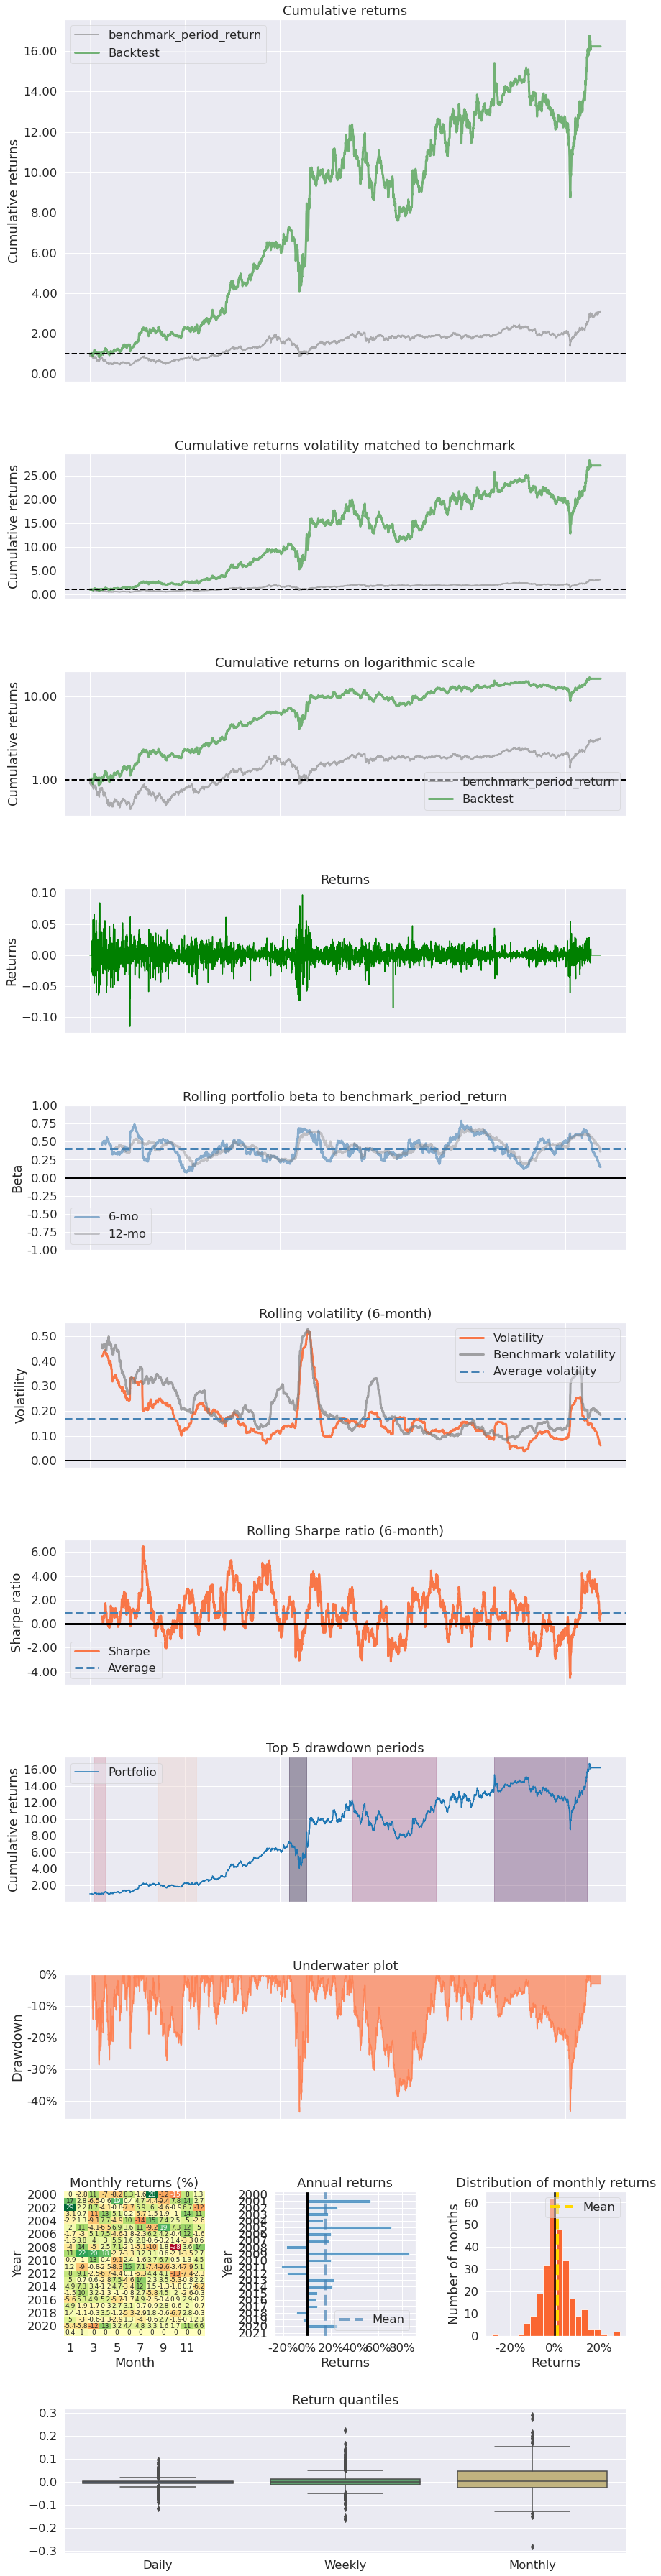

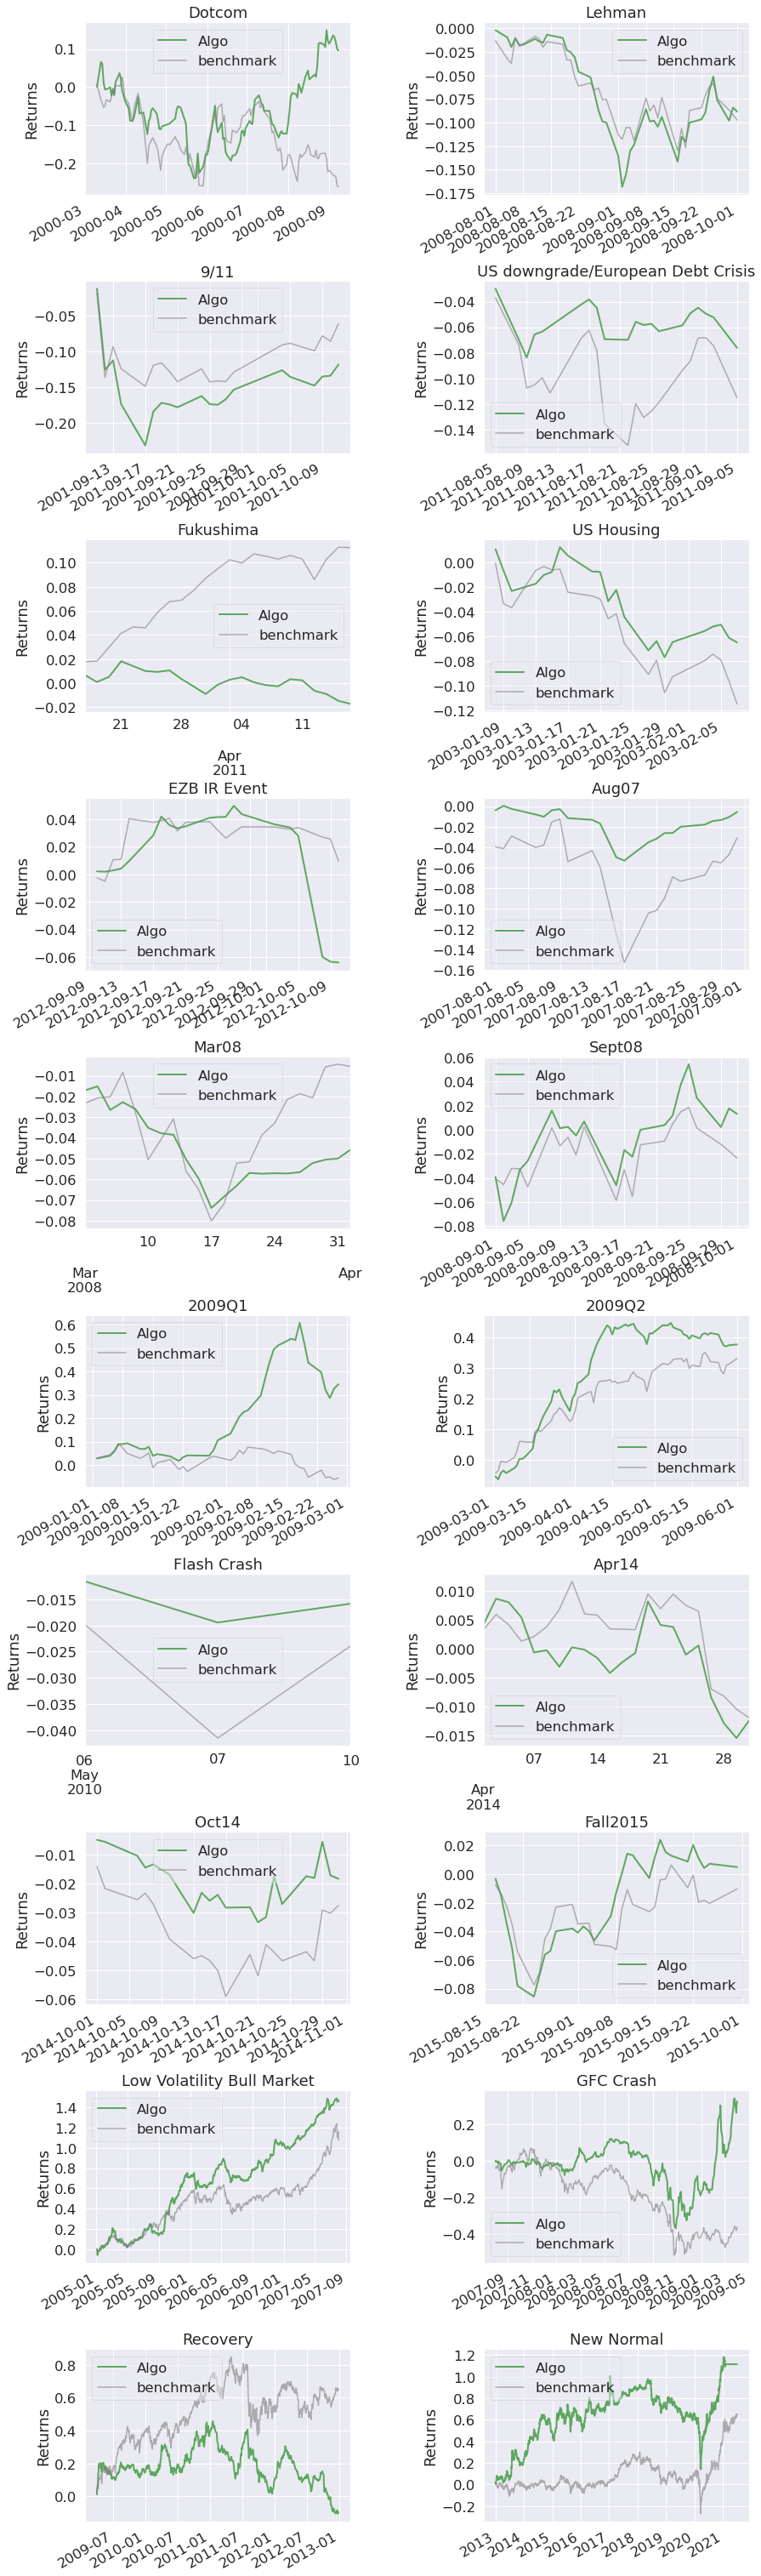

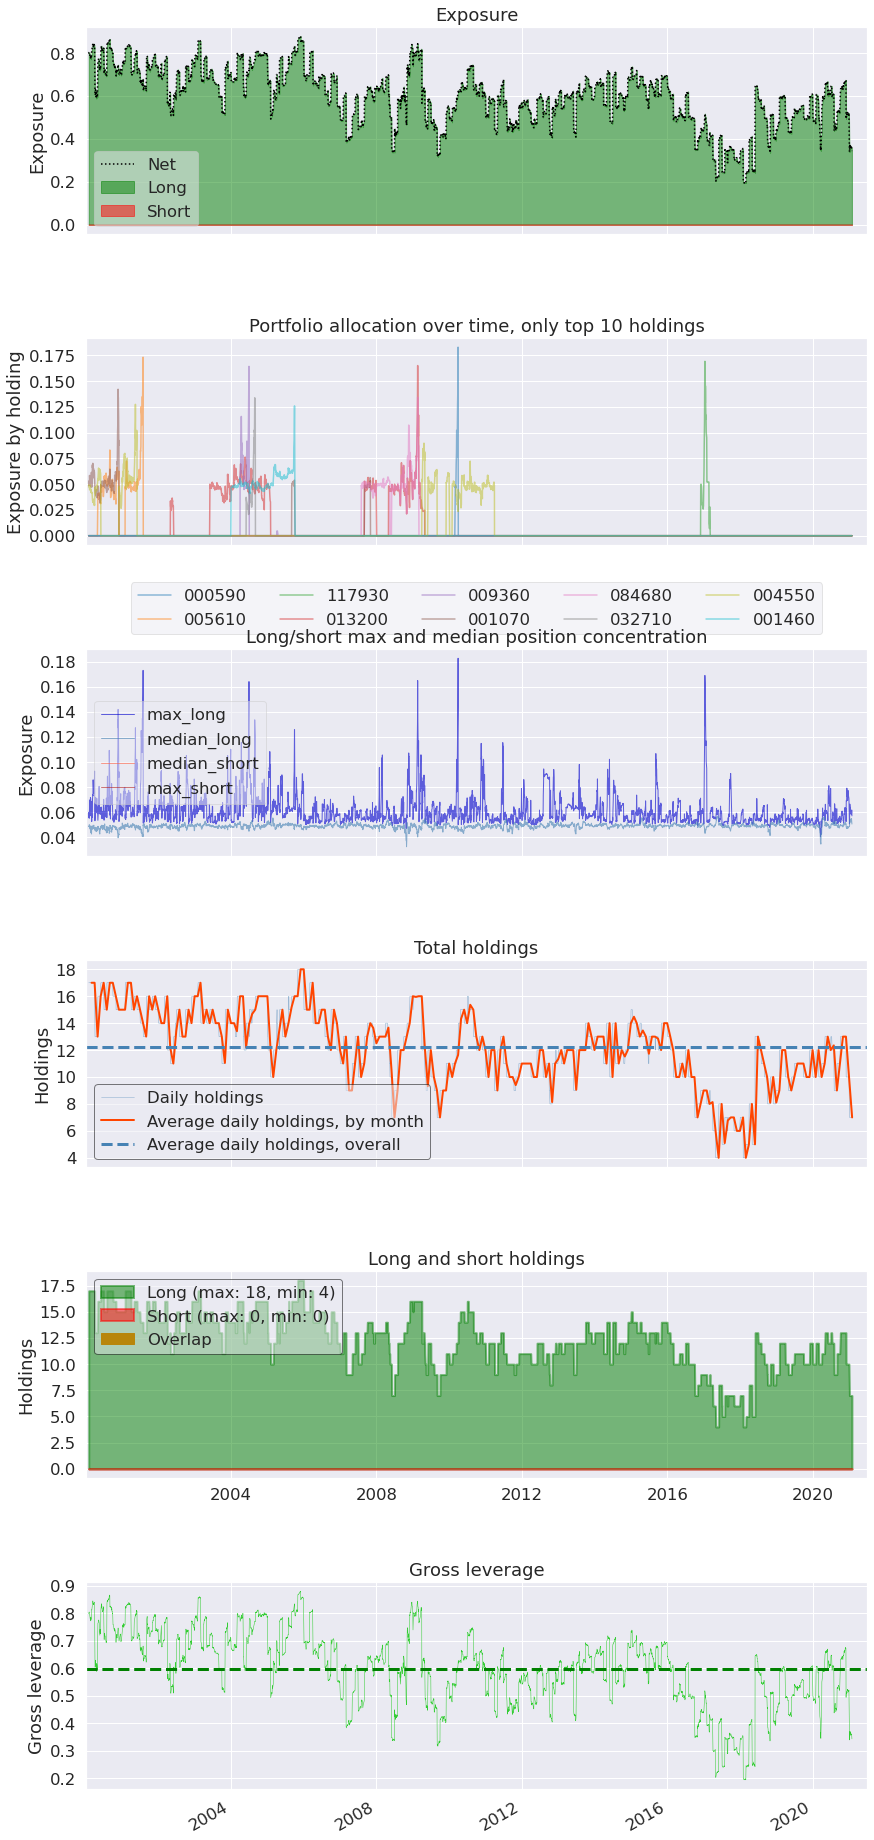

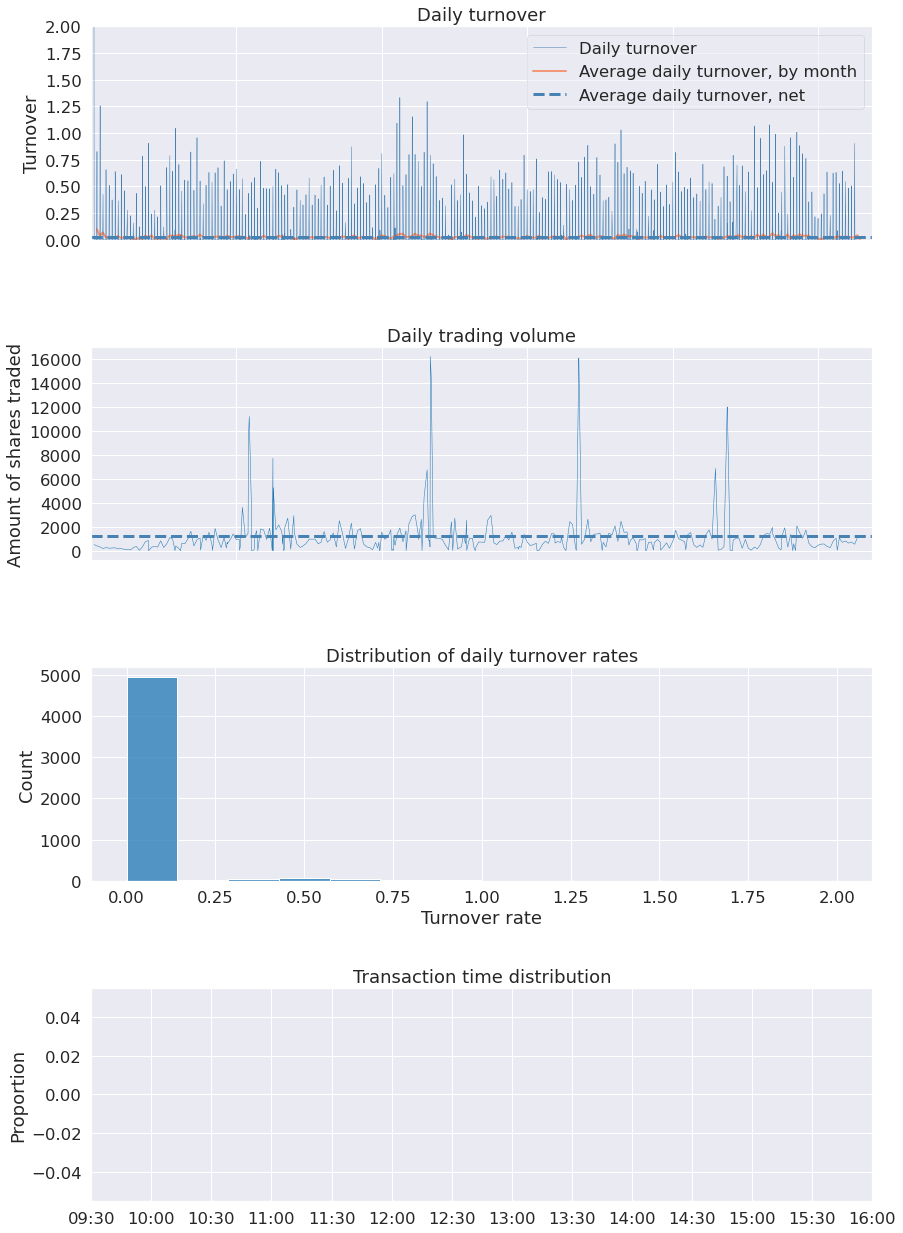

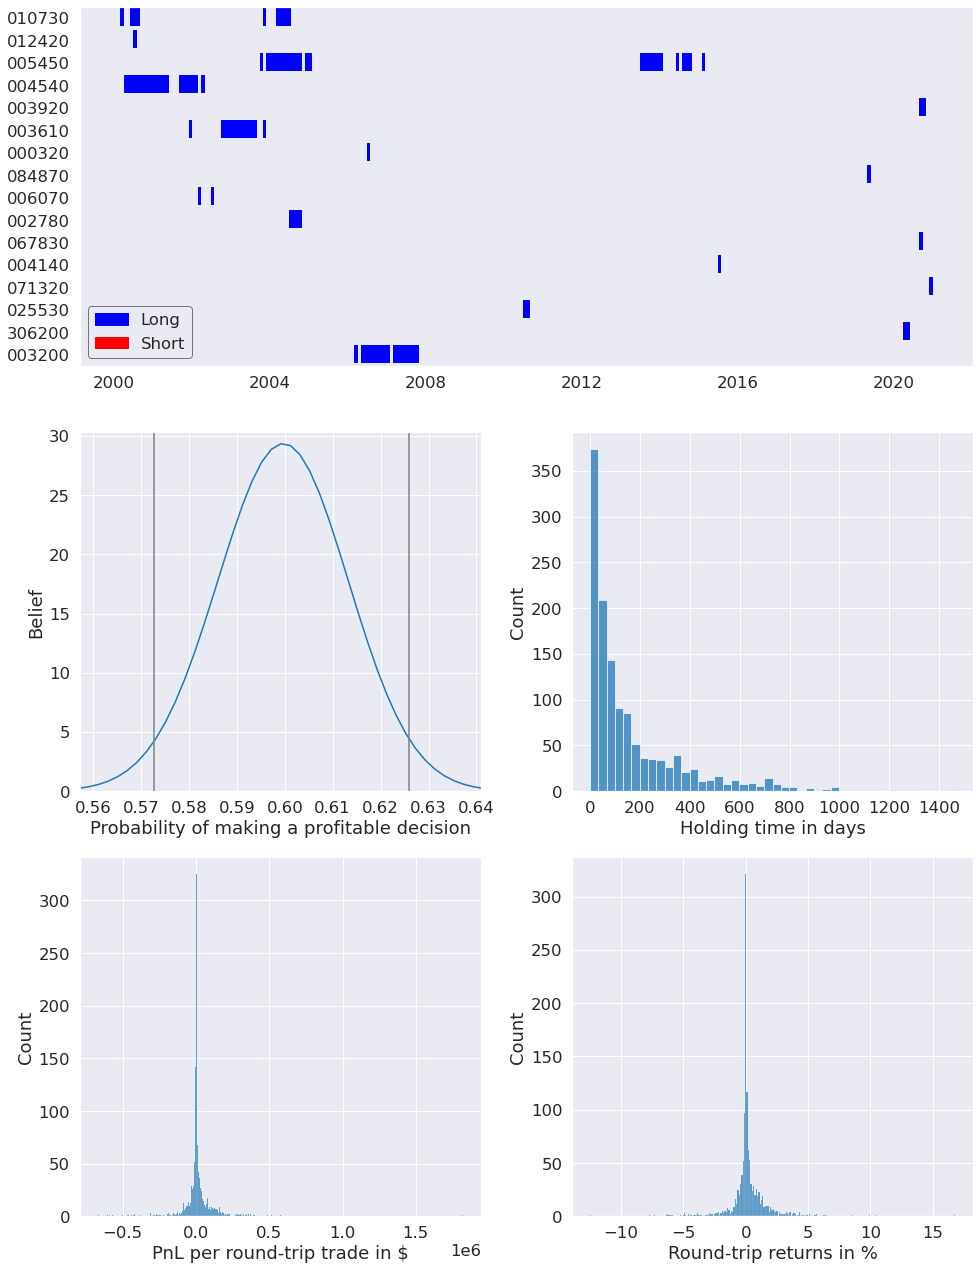

In [113]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          round_trips=True)